In [8]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the dataset
df = pd.read_csv("PERC_mendelly.csv")

# Preprocess the data
def preprocess_text(text):
    # Remove non-alphabetic characters
    text = re.sub('[^A-Za-z]', ' ', text)
    # Tokenize the text
    text = nltk.word_tokenize(text.lower())
    # Remove stopwords
    text = [word for word in text if word not in stopwords.words('english')]
    # Join the words back into a string
    text = ' '.join(text)
    return text

df['Poem'] = df['Poem'].apply(preprocess_text)

# Split the Poem into stanzas
def split_poem_into_stanzas(poem):
    stanzas = sent_tokenize(poem)
    return stanzas

df['Stanzas'] = df['Poem'].apply(split_poem_into_stanzas)

# Define the emotions
emotions = ['love', 'sad', 'anger', 'hate', 'fear', 'surprise', 'courage', 'joy', 'peace',"hope",'care']

# Convert the emotions into numerical labels
label_dict = {emotion: idx for idx, emotion in enumerate(emotions)}

df['Label'] = df['Emotion'].map(label_dict)

# Convert the stanzas into numerical sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Poem'])
sequences = tokenizer.texts_to_sequences(df['Poem'])
word_index = tokenizer.word_index
max_sequence_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Convert the labels into one-hot vectors
labels = to_categorical(np.asarray(df['Label']))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Define the model architecture
model = Sequential()
model.add(Embedding(len(word_index) + 1, 128, input_length=max_sequence_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(len(emotions), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

Epoch 1/10


ValueError: in user code:

    C:\Users\DELL\Anaconda3\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\DELL\Anaconda3\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\DELL\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\DELL\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\DELL\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\DELL\Anaconda3\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\DELL\Anaconda3\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\DELL\Anaconda3\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\DELL\Anaconda3\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\DELL\Anaconda3\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\DELL\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\DELL\Anaconda3\lib\site-packages\keras\losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\DELL\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\DELL\Anaconda3\lib\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\DELL\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 10) and (None, 11) are incompatible


Accuracy: 0.36072144288577157
Confusion Matrix: [[83 58 11  0  3  0 14 14 10  3  1]
 [23 92 12  1  2  4  9 24  5  3  0]
 [17 28 36  0  3  1 10 12  8  1  0]
 [ 2 18  1  0  0  1  0  1  1  0  0]
 [ 7 11  2  0  5  0  6  3  3  3  1]
 [ 2 12  2  0  1  6  0  3  3  1  0]
 [15 20  9  0  2  3 27 10  6  0  0]
 [13 49 12  0  3  3 10 63  9  2  0]
 [11 20 11  0  0  1  5 12 21  0  0]
 [ 5  9  1  0  0  0  5  4  5 16  2]
 [ 6  2  4  0  1  2  1  2  0  2 11]]


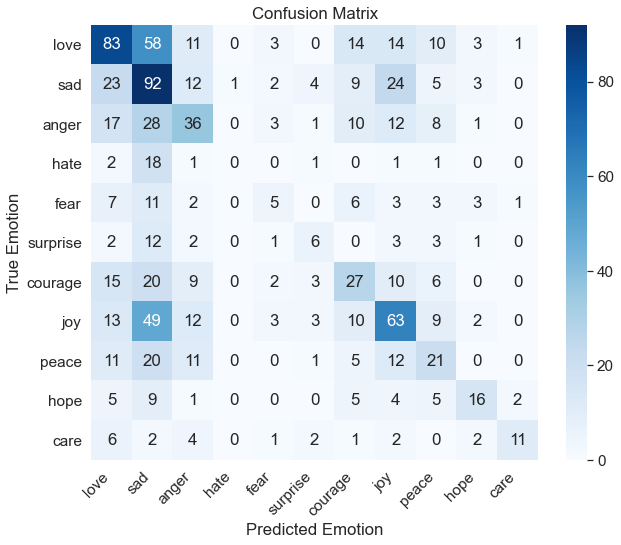

In [9]:
print('Accuracy:', accuracy)
print('Confusion Matrix:', cm)
import matplotlib.pyplot as plt
import seaborn as sns
# Create a figure and axis
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)  # Adjust the font size for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(emotions))+0.5, labels=emotions, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(emotions))+0.5, labels=emotions, rotation=0)

# Display the plot
plt.show()

In [8]:
model.save("poem_emotion_detection.h5")

In [13]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('poem_emotion_detection.h5')

# Load the test data
test_df = pd.read_csv('test.csv')
max_length = max([len(sequence) for sequence in train_sequences])
train_data = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_data = pad_sequences(test_sequences, maxlen=max_length, padding='post')


# Preprocess the test data
test_sequences = tokenizer.texts_to_sequences(test_df['Poem'])
test_data = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Make predictions
predictions = model.predict(test_data)

# Map predicted labels to emotion names
emotion_map = {0: 'Anger', 1: 'Courage', 2: 'Fear', 3: 'Hate', 4: 'Joy', 5: 'Love', 6: 'Peace', 7: 'Sadness', 8: 'Surprise'}
predicted_emotions = [emotion_map[np.argmax(pred)] for pred in predictions]

# Add predicted emotions to the test data
test_df['Predicted Emotion'] = predicted_emotions

# Save the predictions to a CSV file
test_df.to_csv('test_predictions.csv', index=False)


NameError: name 'train_sequences' is not defined